In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# from google.colab.patches 
# import cv2_imshow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm import tqdm
from PIL import Image
import albumentations as A

# import cv2
# import cv2_imshow
import torch
import torch.nn as nn
from torchvision import transforms
import random
import torch.utils.data as Dataset
import torch.optim as optim
from albumentations.pytorch import ToTensorV2


In [4]:
# 예제 사용
image_dir = 'data/train'

EDA

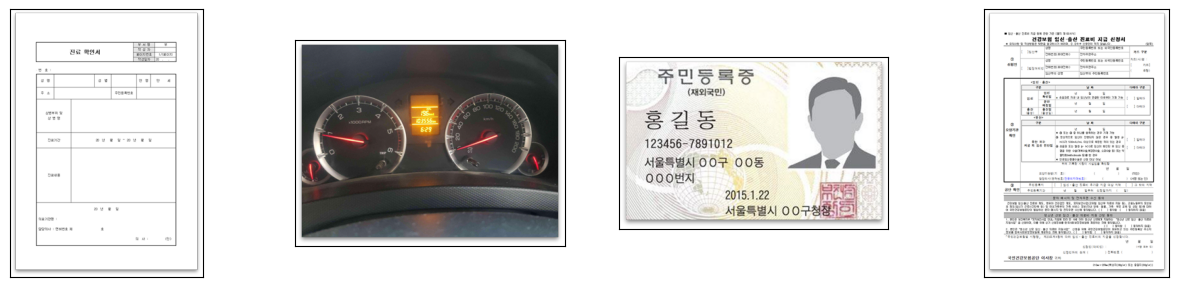

In [6]:
# 이미지 시각화 함수(16개)
def visualize_image(image_dir, num_images_to_display=16):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))][:num_images_to_display] # Get image paths from directory

    plt.figure(figsize=(16,16))
    for i, f in enumerate(image_paths): # Iterate over image paths
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = Image.open(f)
        plt.imshow(img)
    plt.show()

visualize_image(image_dir)

Augmentation

In [18]:
def augmentation_pipeline(image_dir, seed=42, min_prob=1.0, max_prob=1.0, augment_round=1):
    random.seed(seed)
    np.random.seed(seed)


    def random_prob(min_prob=0.3, max_prob=1.0):
        return random.uniform(min_prob, max_prob)

    transform_scale = [
        A.Downscale(scale_min=0.455, scale_max=0.5, interpolation=2, p=0.5), # 이미지의 해상도를 낮춤
        A.RandomScale(scale_limit=(0.8, 1.2), p=0.5)
        # A.Resize(height=256, width=256, p=1.0)
    ]
# crop은 이미지를 자르므로 p를 세심하게 고려
    transform_crop = [

        A.RandomCrop(width=224, height=224, p=0.5),
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), p=0.3),
        # A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),  # 이미지의 일부 영역을 자르기
        A.CoarseDropout(max_holes=8 ,max_height=16 , max_width=16, p=0.5) # 이미지의 일부 영역을 사각형 블록으로 가림
    ]
    transform_flip = [
        A.VerticalFlip(p=1.0),
        A.HorizontalFlip(p=1.0),
    ]
    transform_rotate = [
        A.RandomRotate90(p=1.0),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=1.0),
    ]
    transform_color = [
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=1.0),
    ]
    transform_shade = [
        A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, p=1.0),
        A.RandomSunFlare(flare_roi=(0, 0.5, 1, 0.75), angle_lower=0,p=1.0)
    ]
    # tone에 관해 강건하게 만들고 싶다면 p를 낮추자
    transform_tone = [
        A.ToGray(p=0.2), # 이미지를 흑백으로 변환
        A.ToSepia(p=0.2) # 이미지를 세피아 이미지로 변환
    ]
    transform_light = [
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
        A.Equalize(mode='cv',by_channels=True,p=1.0), # 이미지의 히스토그램을 평탄화하여 밝기 분포를 균일하게
        A.CLAHE(p=1.0)       # 명암 제한 적응형 히스토그램 평활화
    ]

    transform_distortion = [
        A.GridDistortion(num_steps=5,distort_limit=0.3, p=1.0),
        A.OpticalDistortion(distort_limit=0.3, shift_limit=0.2, p=1.0)
    ]
    transform_noise = [
        A.GaussNoise(var_limit=(10, 50), p=1.0),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=1.0)
    ]
    transform_blur = [
        A.Blur(blur_limit=(3,7), p=1.0),
        A.MedianBlur(blur_limit=(3,7), p=1.0),
        A.MotionBlur(blur_limit=(3,7), p=1.0)
    ]
    transform_edge = [
        A.Emboss(p=1.0),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0)
    ]
    transform_shuffle = [
        A.ChannelShuffle(p=1.0),
        A.RandomGridShuffle(grid=(3, 3), p=1.0)
    ]


    transform_all = A.Compose([
        # transform_resize,
        A.OneOf(transform_scale, p=random_prob(min_prob,max_prob)),
        A.OneOf(transform_crop, p=random_prob(min_prob,max_prob)),
        A.OneOf(transform_flip, p=random_prob(min_prob,max_prob)),
        A.OneOf(transform_rotate, p=random_prob(min_prob,max_prob)),
        A.OneOf(transform_color, p=random_prob(min_prob,max_prob)),
        A.OneOf(transform_shade, p=random_prob(min_prob,max_prob)),
        A.OneOf(transform_blur, p=random_prob(min_prob,max_prob)),
        A.OneOf(transform_distortion, p=random_prob(min_prob,max_prob)),
        A.OneOf(transform_noise, p=random_prob(min_prob,max_prob)),
        A.OneOf(transform_edge, p=random_prob(min_prob,max_prob)),
        A.OneOf(transform_shuffle, p=random_prob(min_prob,max_prob)),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
        ToTensorV2(p=1.0) # 텐서 변환
    ])

    # 증강 이미지 저장 폴더 생성
    augmented_dir = os.path.join(image_dir, "증강이미지 폴더")
    os.makedirs(augmented_dir, exist_ok=True)

    # 이미지 파일 목록 가져오기
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    augmented_images = []  # 증강된 이미지 정보를 저장할 리스트

    for _ in range(augment_round):
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            image = cv2.imread(image_path)

            for _ in range(augment_round):
                # 증강 적용
                augmented = transform_all(image=image)["image"]
                augmented = augmented.permute(1, 2, 0).numpy()  # PyTorch 텐서를 NumPy 배열로 변환
                augmented = cv2.cvtColor(augmented, cv2.COLOR_BGR2RGB)

                # 저장 파일 이름 생성(증강 횟수 추가)
                augmented_file_name = f"augmented_{_+1}_{image_file}"
                augmented_file_path = os.path.join(augmented_dir, augmented_file_name)

                # 증강 이미지 미리보기
                cv2_imshow(augmented)
                cv2.waitKey(0) # 아무 키나 누를 때까지 대기
                cv2.destroyAllWindows() # 창 닫기

                # 증강된 이미지 저장
                # augmented = (augmented * 255).astype(np.uint8)
                cv2.imwrite(augmented_file_path, augmented)

                # 증강된 이미지 정보 저장
                augmented_images.append({
                    "original_file": image_file,
                    "augmented_file": augmented_file_name,
                    "augmented_path": augmented_file_path
                })

    return augmented_images  # 증강된 이미지 정보 반환


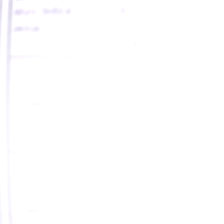

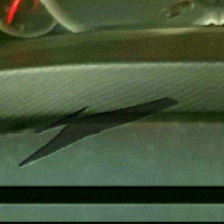

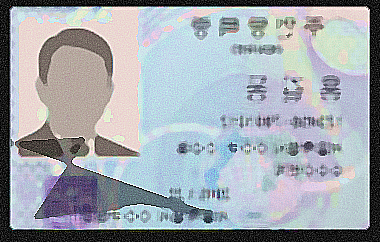

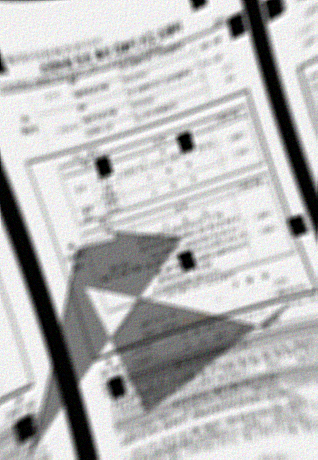

[{'original_file': 'image.png',
  'augmented_file': 'augmented_1_image.png',
  'augmented_path': '/content/drive/MyDrive/AI/Upstage/Doc_Classification_6조/테스트 이미지/증강이미지 폴더/augmented_1_image.png'},
 {'original_file': 'image (2).png',
  'augmented_file': 'augmented_1_image (2).png',
  'augmented_path': '/content/drive/MyDrive/AI/Upstage/Doc_Classification_6조/테스트 이미지/증강이미지 폴더/augmented_1_image (2).png'},
 {'original_file': 'image (3).png',
  'augmented_file': 'augmented_1_image (3).png',
  'augmented_path': '/content/drive/MyDrive/AI/Upstage/Doc_Classification_6조/테스트 이미지/증강이미지 폴더/augmented_1_image (3).png'},
 {'original_file': 'image (4).png',
  'augmented_file': 'augmented_1_image (4).png',
  'augmented_path': '/content/drive/MyDrive/AI/Upstage/Doc_Classification_6조/테스트 이미지/증강이미지 폴더/augmented_1_image (4).png'}]

In [19]:
augmentation_pipeline(image_dir, seed=42, min_prob=0.8, max_prob=1.0, augment_round=1)

In [ ]:
# 다양한 변환 조합(manual)

# trn_transform_1 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.RandomCrop(width=224, height=224),
#     A.HorizontalFlip(),
#     A.VerticalFlip(),
# ])

# trn_transform_2 = A.Compose([
#     A.Rotate(limit=45),
#     A.RandomCrop(width=224, height=224),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45),
#     A.HueSaturationValue(),
#     A.GridDistortion(),
# ])

# trn_transform_3 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),
#     A.HorizontalFlip(),
#     A.VerticalFlip(),
#     A.GaussNoise(var_limit=(100, 500)),
#     A.ISONoise(),
#     A.RandomBrightnessContrast(),
#     A.HueSaturationValue(),
# ])

# trn_transform_4 = A.Compose([
#     A.Rotate(limit=45),
#     A.RandomCrop(width=224, height=224),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45),
#     A.GridDistortion(),
#     A.OpticalDistortion(),
#     A.RandomBrightnessContrast(),
#     A.HueSaturationValue(),
# ])

# trn_transform_5 = A.Compose([
#     A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),
#     A.HorizontalFlip(),
#     A.VerticalFlip(),
#     A.GaussNoise(var_limit=(100, 500)),
#     A.ISONoise(),
#     A.RandomBrightnessContrast(),
#     A.HueSaturationValue(),
#     A.GridDistortion(),
#     A.OpticalDistortion(),
# ])


# transforms_f10 = A.Compose([
#     A.OneOf([
#         A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=(255, 255, 255), mask_value=None, always_apply=True, p=1),
#         A.ElasticTransform(always_apply=True, p=1, alpha=1.0, sigma=50.0, alpha_affine=50.0, interpolation=0, border_mode=1, value=(255, 255, 255), mask_value=None, approximate=False),
#         A.OpticalDistortion(always_apply=True, p=1, distort_limit=(-0.3, -0.1)),
#         A.OpticalDistortion(always_apply=True, p=1, distort_limit=(0.1, 0.3)),
#     ], p=0.5),
#     A.SomeOf([
#         A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=1),
#         A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=20, p=1),
#         A.MultiplicativeNoise(p=1, multiplier=(1, 1.5), per_channel=False),
#         A.Equalize(p=1, mode='cv', by_channels=False),
#     ], n=2, p=0.4),
#     A.CoarseDropout(p=0.4, max_holes=40, max_height=15, max_width=15, min_holes=8, min_height=8, min_width=8),
#     A.OneOf([
#         A.Blur(blur_limit=(3, 4), p=1),
#         A.MotionBlur(blur_limit=(3, 5), p=1),
#         A.Downscale(scale_min=0.455, scale_max=0.5, interpolation=2, p=1),
#     ], p=0.5),
#     A.GaussNoise(var_limit=(400, 1300), per_channel=False, p=0.5),
# ])